<a href="https://colab.research.google.com/github/DanielEdu/BERT_POC/blob/main/BERT_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Análisis de Sentimientos con BERT**

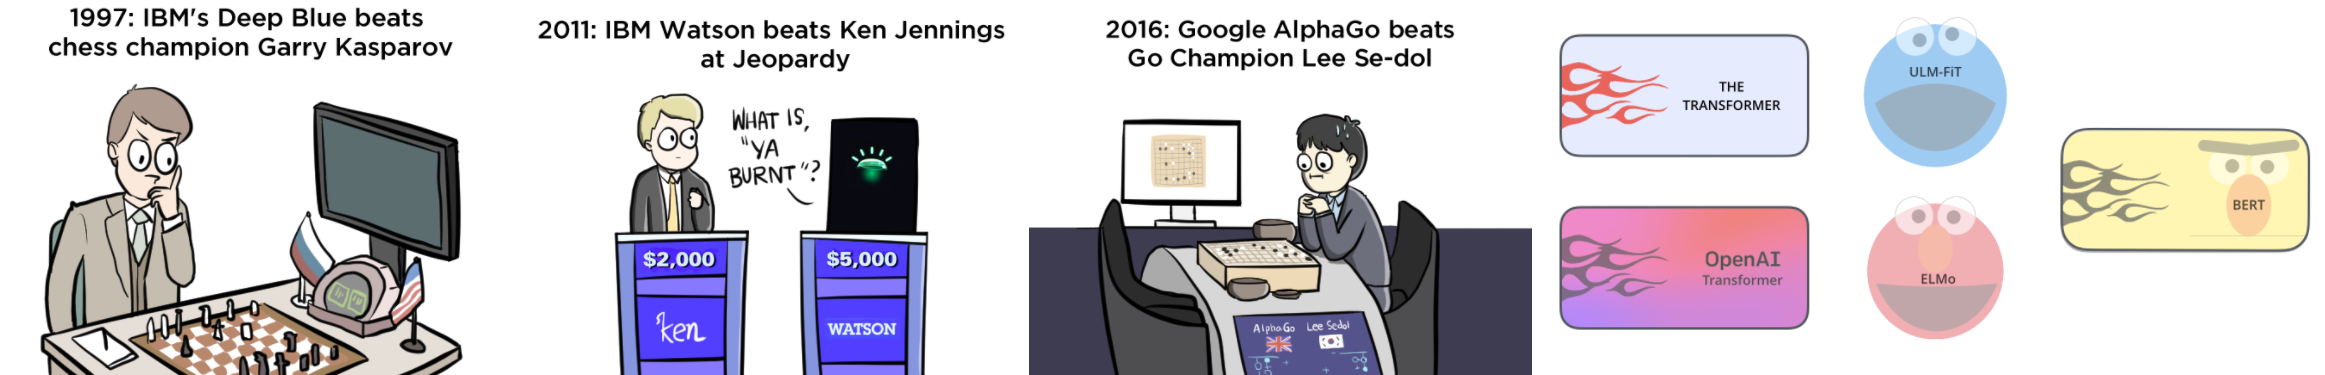

In [71]:
!pip install transformers==4.4.1

     |████████████████████████████████| 2.1MB 7.5MB/s 
  Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


In [1]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

In [2]:
# Initializar 
RANDOM_SEED = 42
MAX_LEN =  200
BATCH_SIZE = 16
DATASET_PATH = '/content/drive/My Drive/DataSets/BERT_sentiment_IMDB_Dataset.csv'
DATASET_PATH_B = '/content/drive/My Drive/DataSets/text_emotion.csv'
NCLASSES = 2 # para comentarios positivos y negativos

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Cargar dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv(DATASET_PATH)
df = df[0:10000]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cargar dataset 2
df_b = pd.read_csv(DATASET_PATH_B)


In [5]:
print(df.head)
print(df.shape)
print("\n".join(wrap(df['review'][200])))

<bound method NDFrame.head of                                                  review sentiment
0     One of the other reviewers has mentioned that ...  positive
1     A wonderful little production. <br /><br />The...  positive
2     I thought this was a wonderful way to spend ti...  positive
3     Basically there's a family where a little boy ...  negative
4     Petter Mattei's "Love in the Time of Money" is...  positive
...                                                 ...       ...
9995  Fun, entertaining movie about WWII German spy ...  positive
9996  Give me a break. How can anyone say that this ...  negative
9997  This movie is a bad movie. But after watching ...  negative
9998  This is a movie that was probably made to ente...  negative
9999  Smashing film about film-making. Shows the int...  positive

[10000 rows x 2 columns]>
(10000, 2)
Interesting and short television movie describes some of the
machinations surrounding Jay Leno's replacing Carson as host of the
Tonight Sho

In [45]:
# B Mulsi sentimientos
df_b.head()
df_b['sentiment'].unique()

sentiment_list = {
    'empty': 1,
    'sadness': 2, 
    'enthusiasm': 3, 
    'neutral': 4,
    'worry': 5,
    'surprise': 6,
    'love': 7,
    'fun': 8,
    'hate': 9,
    'happiness': 10,
    'boredom': 11,
    'relief': 12,
    'anger': 13
}

sentiment_list['empty']

1

In [18]:
# B Reajustar dataset
df_b['label'] = if 
# df.drop('sentiment', axis=1, inplace=True)
df_b.head()

TypeError: ignored

In [6]:
# Reajustar dataset
df['label'] = (df['sentiment']=='positive').astype(int)
df.drop('sentiment', axis=1, inplace=True)
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [7]:
#TOKENIZE
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [8]:
# Ejemplo tokenización
sample_txt = 'I really loved that movie!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  I really loved that movie!
Tokens:  ['I', 'really', 'loved', 'that', 'movie', '!']
Tokens numéricos:  [146, 1541, 3097, 1115, 2523, 106]


In [21]:
# Crear codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [10]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'I', 'really', 'loved', 'that', 'movie', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([ 101,  146, 1541, 3097, 1115, 2523,  106,  102,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [12]:
# CREACIÓN DATASET

class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [13]:
# Data loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

In [14]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
# EL MODELO!

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [16]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

In [17]:
# ENTRENAMIENTO
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [18]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [19]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

TypeError: ignored